LSTM model for predicting (unfiltered) shear stress

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler

from numpy.random import seed
seed(1)

import tensorflow as tf
#tf.random.set_seed(2)


In [ ]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)):
		end_ix = i + n_steps
		if end_ix > len(data):
			break
		samps = np.arange(i,end_ix,10)
		x1, y1 = data[samps, :-1], data[samps[-1], -1]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)
 

In [ ]:
# Load the data

data1 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/p5270MechData/p5270MechData.mat')

m_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'ShearStress':data2['ShearStress'].ravel()})
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'A_filt':data1['A_filt'].ravel(), 'V_filt':data1['V_filt'].ravel(),
                    'T_pc':data1['T_pc'].ravel(), 'Vel_pc':data1['Vel_pc'].ravel(), 'T_der':data1['T_der'].ravel(), 'Vel_der':data1['Vel_der'].ravel()})  

df = a_t.merge(m_t, on='Time')

print("Input data:", df.shape)


Input data: (132399, 8)


In [ ]:
# Preprocessing

df = df.drop(['Time', 'T_der', 'Vel_der', 'T_pc', 'Vel_pc'], axis=1)  # Drop irrelevant features 

arr = df.to_numpy()
n_steps = 300
xdf, ydf = create_timesteps(arr, n_steps)

# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
num_instances, num_time_steps, num_features = X_train.shape
X_train = scaler.fit_transform(np.reshape(X_train, (-1, num_features)))
X_train = np.reshape(X_train, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = X_val.shape
X_val = scaler.transform(np.reshape(X_val, (-1, num_features)))
X_val = np.reshape(X_val, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = x_test.shape
x_test = scaler.transform(np.reshape(x_test, (-1, num_features)))
x_test = np.reshape(x_test, (num_instances, num_time_steps, num_features))

print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Training: (95112, 30, 2)
Validation: (10568, 30, 2)
Testing: (26420, 30, 2)


Epoch 1/10
2973/2973 [==============================] - 140s 47ms/step - loss: 0.6468 - val_loss: 0.0154
Epoch 2/10
2973/2973 [==============================] - 139s 47ms/step - loss: 0.0066 - val_loss: 0.0046
Epoch 3/10
2973/2973 [==============================] - 132s 44ms/step - loss: 0.0025 - val_loss: 0.0039
Epoch 4/10
2973/2973 [==============================] - 134s 45ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 5/10
2973/2973 [==============================] - 137s 46ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 6/10
2973/2973 [==============================] - 139s 47ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 7/10
2973/2973 [==============================] - 132s 44ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 8/10
2973/2973 [==============================] - 137s 46ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 9/10
2973/2973 [==============================] - 139s 47ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 10/10
2973/2973 [==============================] 

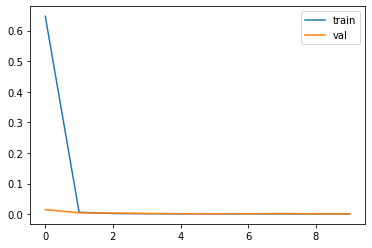

In [ ]:
# Build the model

model = Sequential()
model.add(LSTM(128, activation='relu', kernel_initializer='normal', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model

y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

y_predTest = model.predict(x_test)
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("R2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_r2, val_r2, test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_rmse, val_rmse, test_rmse))


R2 scores: Train - 0.94314, Validation - 0.94042, Test - 0.91433
RMSE scores: Train - 0.03108, Validation - 0.03665, Test - 0.04308


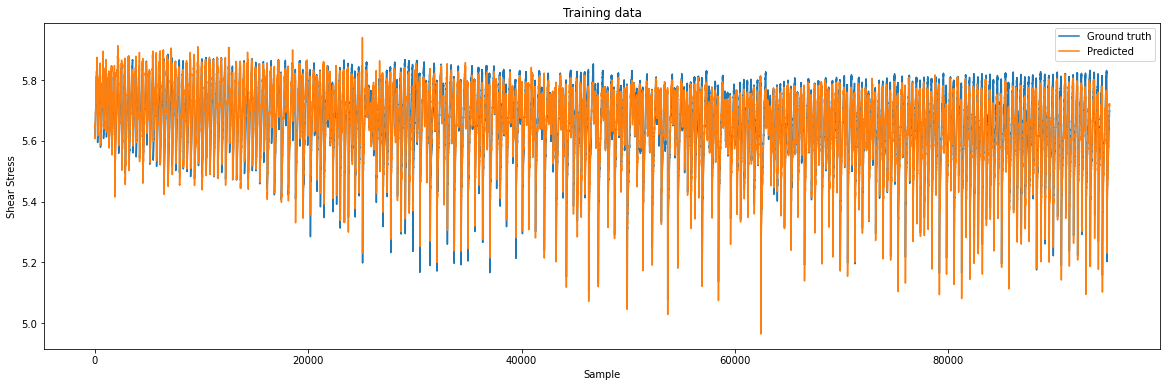

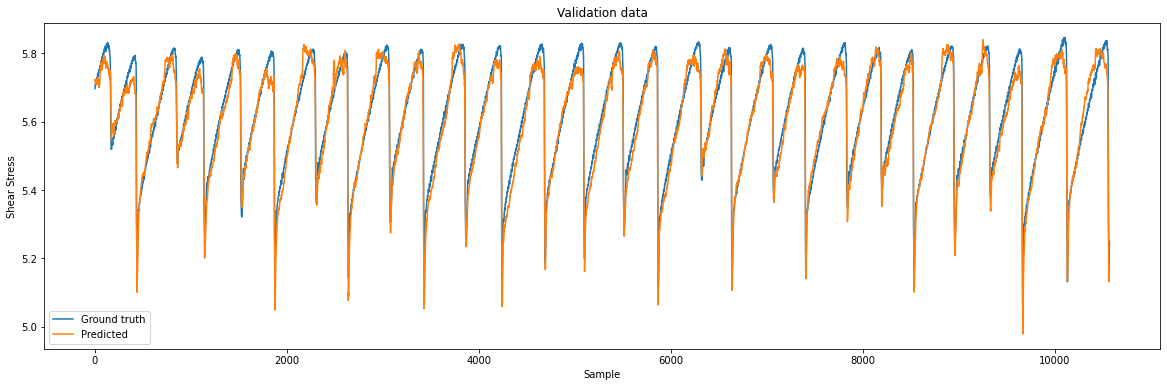

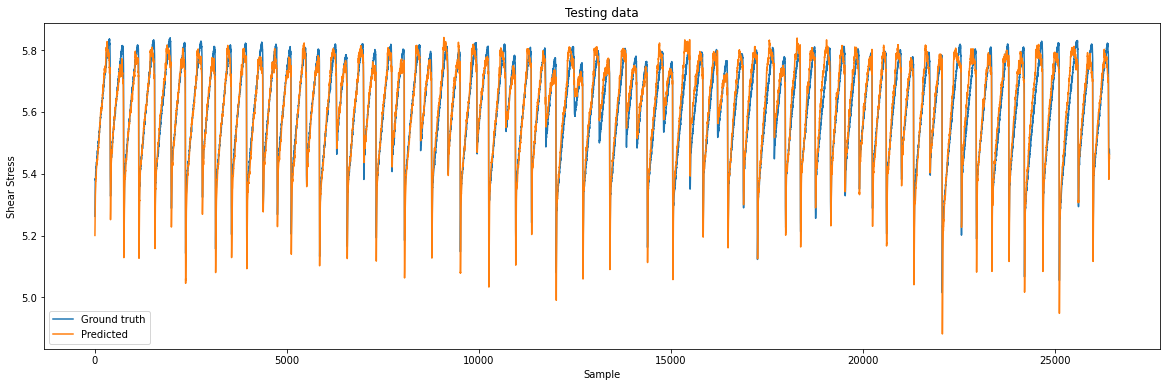

In [ ]:
# Results plot

def results_plot(fig_no, gt, pred, title):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(gt)
  plt.plot(pred)
  plt.xlabel('Sample')
  plt.ylabel('Shear Stress')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, Y_train, y_predTrain, 'Training data')
results_plot(2, Y_val, y_predVal, 'Validation data')
results_plot(3, y_test, y_predTest, 'Testing data')


Text(0.5, 1.0, '5000 Samples, Testing Data')

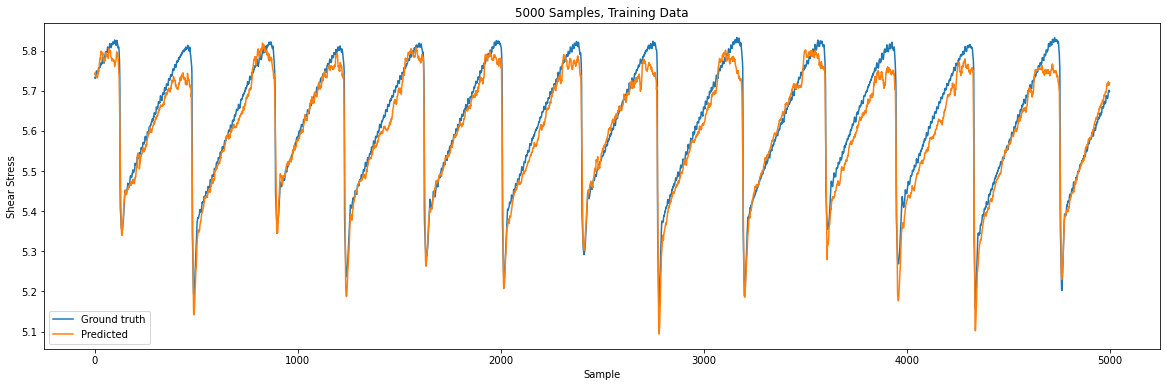

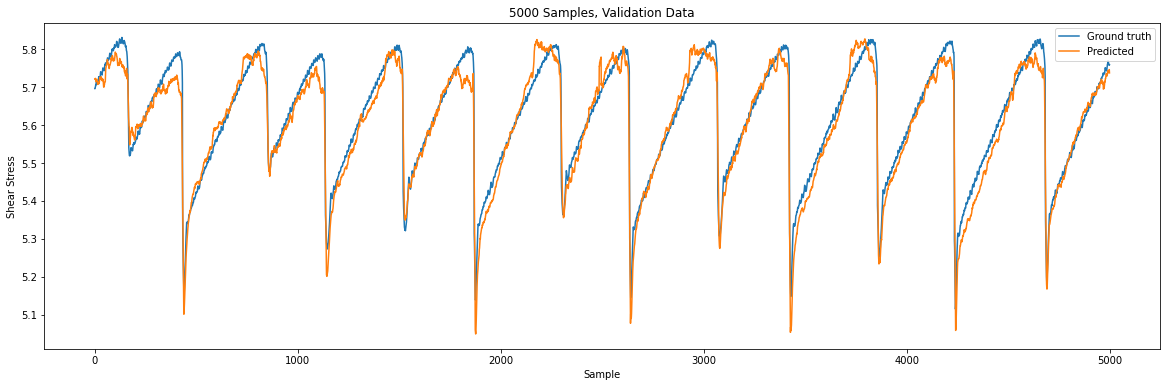

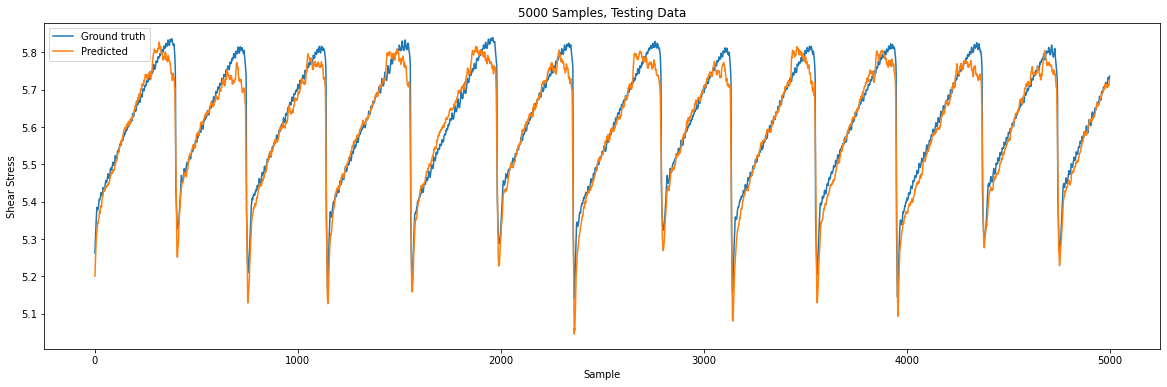

In [ ]:
# Detailed view of the plots

fig = plt.figure(4, figsize=(20,6))
plt.plot(Y_train[-5000:])
plt.plot(y_predTrain[-5000:])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(Y_val[:5000])
plt.plot(y_predVal[:5000])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Validation Data')

fig = plt.figure(6, figsize=(20,6))
plt.plot(y_test[:5000])
plt.plot(y_predTest[:5000])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Testing Data')


Text(0.5, 1.0, 'Shear Stress')

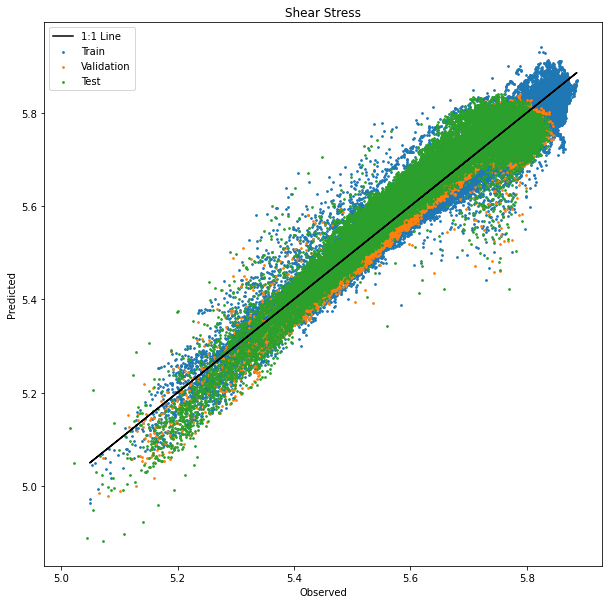

In [ ]:
# Regression analysis
fig = plt.figure(7, figsize=(10,10))
plt.plot(Y_train, Y_train, 'black')
plt.scatter(Y_train, y_predTrain, s=3)
plt.scatter(Y_val, y_predVal, s=3)
plt.scatter(y_test, y_predTest, s=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(['1:1 Line','Train', 'Validation', 'Test'])
plt.title('Shear Stress')